<a href="https://colab.research.google.com/github/yonayaha/geometry/blob/master/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install environment


In [1]:
!apt install libspatialindex-dev
!pip install rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 4s (132 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [2]:
!git clone https://github.com/yonayaha/geometry.git

Cloning into 'geometry'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 63 (delta 37), reused 44 (delta 21), pack-reused 3
Unpacking objects: 100% (63/63), done.


# Run environment

In [3]:
# import necessary components and define reusable functions

import sys
import numpy as np
from matplotlib import pyplot as plt, patches
import random
import pickle
import time

sys.path.append('geometry/')
from shapely_extension import *
from obstacle_metric import ObstacleMetric

def select_random_point():
  bounds = om.obstacle_surface.bounds
  while True:
    x = bounds[0] + random.random() * (bounds[2] - bounds[0])
    y = bounds[1] + random.random() * (bounds[3] - bounds[1])
    point = Point(x, y)
    if om.obstacle_surface.contains(point):
      return point

def plot_point(point, color):
  plt.gca().add_patch(patches.Circle((point.x, point.y), facecolor=color, alpha=1))

def plot_segment(point0, point1, color):
  plt.plot([point0.x, point1.x], (point0.y, point1.y), color=color)

def plot_polygon(polygon, color):
  plt.gca().add_patch(patches.Polygon(list(zip(*polygon.xy)), facecolor=color, alpha=1))

def plot_plain_surface():
  plot_polygon(om.bounding_box, 'black')
  plot_polygon(om.obstacle_surface.exterior, 'white')
  for obstacle_linestring in om.obstacle_surface.interiors:  
    plot_polygon(obstacle_linestring, 'black')

  plt.xlim(om.bounding_box.bounds[0:4:2])
  plt.ylim(om.bounding_box.bounds[1:4:2])

print('Done')

Done


# Build obstacle-metric structure

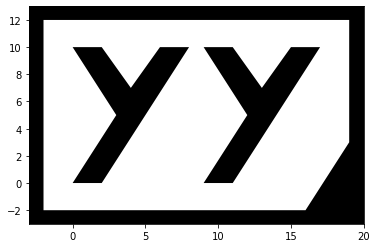

In [4]:
# define obstacle surface

surface = Polygon([[-2,-2],[-2,12],[19,12],[19,3],[16,-2]])
obstacles = [
  Polygon([[0,0],[3,5],[0,10],[2,10],[4,7],[6,10],[8,10],[2,0]]),
  Polygon([[9,0],[12,5],[9,10],[11,10],[13,7],[15,10],[17,10],[11,0]])
]
om = ObstacleMetric(surface, obstacles)

# preview
plot_plain_surface()
plt.show()

Building visibility graph...
Done within 0.11148810386657715 sec


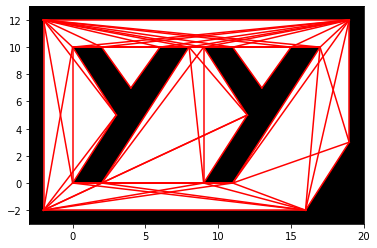

In [5]:
# build visibility graph

print('Building visibility graph...')
t0 = time.time()
om.build_visibility_graph()
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
for point0, point1 in om.visibility_graph.edges:
  plot_segment(point0, point1, '#ff0000')
# for point in om.visibility_graph.nodes:
#   plot_point(point, '#ff0000')
plt.show()

Bbuilding visibility subdivision...
Done within 1.3060886859893799 sec


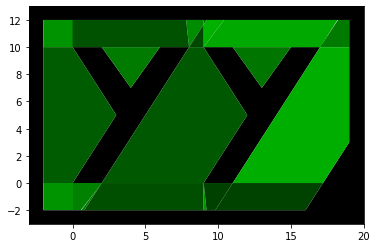

In [6]:
# build visibility subdivision

print('Bbuilding visibility subdivision...')
t0 = time.time()
om.build_visibility_subdivision(tol=0.01)
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
for polygon in om.polygon_visibility_points:
  color = '#00' + hex(random.randint(64, 191))[2:] + '00'
  plot_polygon(polygon.exterior, color)
plt.show()

# Test calculations

Selecting random point...
Calculating visible points...
Done within 0.0007181167602539062 sec


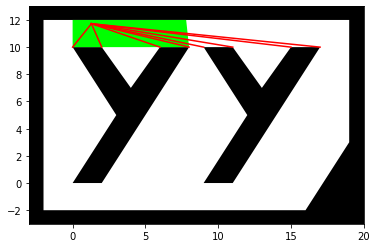

In [7]:
# Calculate containing polygon and visible points for a random point

print('Selecting random point...')
point = select_random_point()
print('Calculating visible points...')
t0 = time.time()
visible_points = om.get_visible_points(point)
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
polygon = om.get_containing_polygon(point)
plot_polygon(polygon.exterior, '#00ff00')
# plot_point(point, '#ff0000')
for visible_point in visible_points:
  plot_segment(point, visible_point, '#ff0000')
plt.show()

Selecting random points...
Calculating shortest path...
Done within 0.016197919845581055 sec


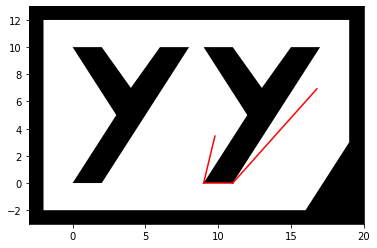

In [8]:
print('Selecting random points...')
point0 = select_random_point()
point1 = select_random_point()
print('Calculating shortest path...')
t0 = time.time()
shortest_path = om.get_shortest_path(point0, point1)
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
# plot_point(point0, '#ff0000')
# plot_point(point1, '#ff0000')
for mid_point0, mid_point1 in zip(shortest_path[:-1], shortest_path[1:]):
  plot_segment(mid_point0, mid_point1, '#ff0000')
plt.show()


Selecting random point...
Building point-path machine...
Done within 0.019359588623046875 sec


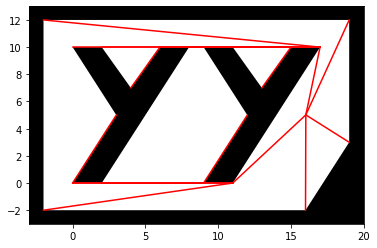

In [26]:
# Build point-path machine

print('Selecting random point...')
point0 = select_random_point()
print('Building point-path machine...')
t0 = time.time()
point_path_machine = om.get_point_path_machine(point0, cutoff=None)
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
# plot_point(point0, '#ff0000')
segments = set()
for point1 in om.points():
  shortest_path = point_path_machine(point1)
  for mid_point0, mid_point1 in zip(shortest_path[:-1], shortest_path[1:]):
    segments.add((mid_point0, mid_point1))
for mid_point0, mid_point1 in segments:
  plot_segment(mid_point0, mid_point1, '#ff0000')
plt.show()


Selecting random point...
Calculating path...
Done within 0.0016388893127441406 sec


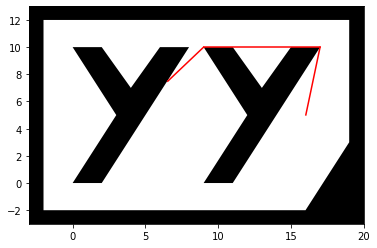

In [33]:
# Use pre-calculated point-path machine to calculate path to a random point

print('Selecting random point...')
point1 = select_random_point()
print('Calculating path...')
t0 = time.time()
shortest_path = point_path_machine(point1)
shortest_path.append(point1)
print(f'Done within {time.time() - t0} sec')

# preview
plot_plain_surface()
# plot_point(point0, '#ff0000')
# plot_point(point1, '#ff0000')
for mid_point0, mid_point1 in zip(shortest_path[:-1], shortest_path[1:]):
  plot_segment(mid_point0, mid_point1, '#ff0000')
plt.show()
